In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0'
df = pd.read_csv(os.path.join(path, 'subject-info.csv'))
df.head(10)

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0
5,Subject05,16,F,2010,20.71,1
6,Subject06,18,M,2011,4.35,0
7,Subject07,18,F,2012,13.38,1
8,Subject08,26,M,2011,18.24,1
9,Subject09,16,F,2010,7.00,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Subject                 36 non-null     object 
 1   Age                     36 non-null     int64  
 2   Gender                  36 non-null     object 
 3   Recording year          36 non-null     int64  
 4   Number of subtractions  36 non-null     float64
 5   Count quality           36 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.8+ KB


In [ ]:
def encodeGender(row):
    return 0 if row['Gender']=='M' else 1  # Encode Gender: M=0, F=1

def encodeNumberSubtractions(row):
    return int(row['Number of subtractions'])

# Encoding specific categorical features
df['Gender'] = df.apply(encodeGender, axis=1)
df['Number of subtractions'] = df.apply(encodeNumberSubtractions, axis=1)
df.head(10)

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,1,2011,9,0
1,Subject01,18,1,2011,29,1
2,Subject02,19,1,2012,12,1
3,Subject03,17,1,2010,31,1
4,Subject04,17,1,2010,8,0
5,Subject05,16,1,2010,20,1
6,Subject06,18,0,2011,4,0
7,Subject07,18,1,2012,13,1
8,Subject08,26,0,2011,18,1
9,Subject09,16,1,2010,7,0


In [ ]:
print('No. of Females :',df['Gender'].sum())

No. of Females : 27


Therefore,

No. of Male subjects = 9

No. of Female subjects = 27

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.6 MB/s eta 0:00:00


In [ ]:
import mne
def load_edf(file_path):
    return mne.io.read_raw_edf(file_path, preload=True)

# Loading EDF files
df['rest_data'] = df.apply(lambda row: load_edf(os.path.join(path, f"{row['Subject']}_1.edf")), axis=1)
df['task_data'] = df.apply(lambda row: load_edf(os.path.join(path, f"{row['Subject']}_2.edf")), axis=1)

Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/MyDrive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.

Choice of Frequency Bands for analysis :

Delta (1-4 Hz): Delta waves are typically associated with deep sleep, not cognitive tasks.

Theta (4-8 Hz): Theta waves indicates changes in drowsiness or relaxation levels.

Alpha (8-12 Hz): Alpha waves are linked to relaxation and closed-eye states.

Beta (12-30 Hz): Beta activity is associated with active thinking and concentration.

Gamma (30-100 Hz): Gamma waves are associated with various cognitive and physiological functions.

Using Power Spectral Density (PSD), a concept in signal processing used to describe how the power of a signal or time series is distributed across different frequency components for analysis.

In [ ]:
# Defining frequency bands
freq_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

# Compute the PSD using the welch method
def compute_psd(raw, fmin, fmax):
    psd_obj = raw.compute_psd(method='welch', fmin=fmin, fmax=fmax, n_fft=2048)
    psd = psd_obj.get_data()
    freqs = psd_obj.freqs
    return psd.mean(axis=1), freqs


In [ ]:
# Compute PSDs for all and gender-wise
psd_rest_all = {band: [] for band in freq_bands.keys()}
psd_task_all = {band: [] for band in freq_bands.keys()}
psd_rest_all_male = {band: [] for band in freq_bands.keys()}
psd_task_all_male = {band: [] for band in freq_bands.keys()}
psd_rest_all_female = {band: [] for band in freq_bands.keys()}
psd_task_all_female = {band: [] for band in freq_bands.keys()}

for index, row in df.iterrows():
    rest = row['rest_data']
    task = row['task_data']
    gender = row['Gender']

    for band, (fmin, fmax) in freq_bands.items():
        psd_rest, _ = compute_psd(rest, fmin, fmax)
        psd_task, _ = compute_psd(task, fmin, fmax)
        psd_rest_all[band].append(psd_rest)
        psd_task_all[band].append(psd_task)

        if gender == 0:         # Male
            psd_rest_all_male[band].append(psd_rest)
            psd_task_all_male[band].append(psd_task)
        else:                   # Female
            psd_rest_all_female[band].append(psd_rest)
            psd_task_all_female[band].append(psd_task)

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Effective wind

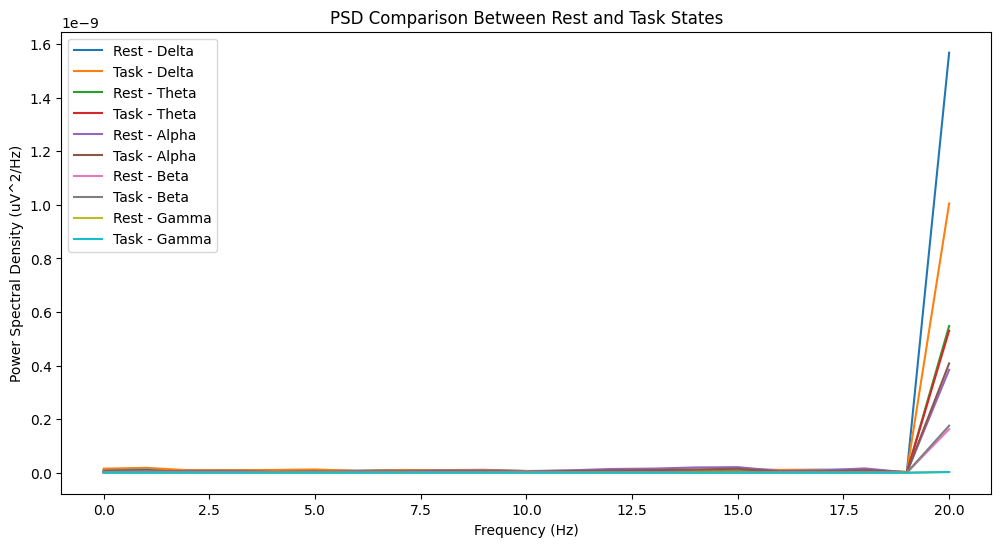

In [ ]:
# Visualize PSD comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for band in freq_bands.keys():
    plt.plot(np.mean(psd_rest_all[band], axis=0), label=f'Rest - {band}')
    plt.plot(np.mean(psd_task_all[band], axis=0), label=f'Task - {band}')
plt.legend()
plt.title('PSD Comparison Between Rest and Task States')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (uV^2/Hz)')
plt.show()

-> This graph shows the PSD comparison between rest and task states for different frequency bands across all subjects.

-> There is a noticeable increase in power at higher frequencies, particularly around the 20 Hz mark. This peak is likely due to the frequency resolution and sampling parameters.

-> The PSD differences between rest and task states are subtle in the higher frequencies(like Theta, Alpha, Beta, and Gamma) but more in lower frequency (like Delta).

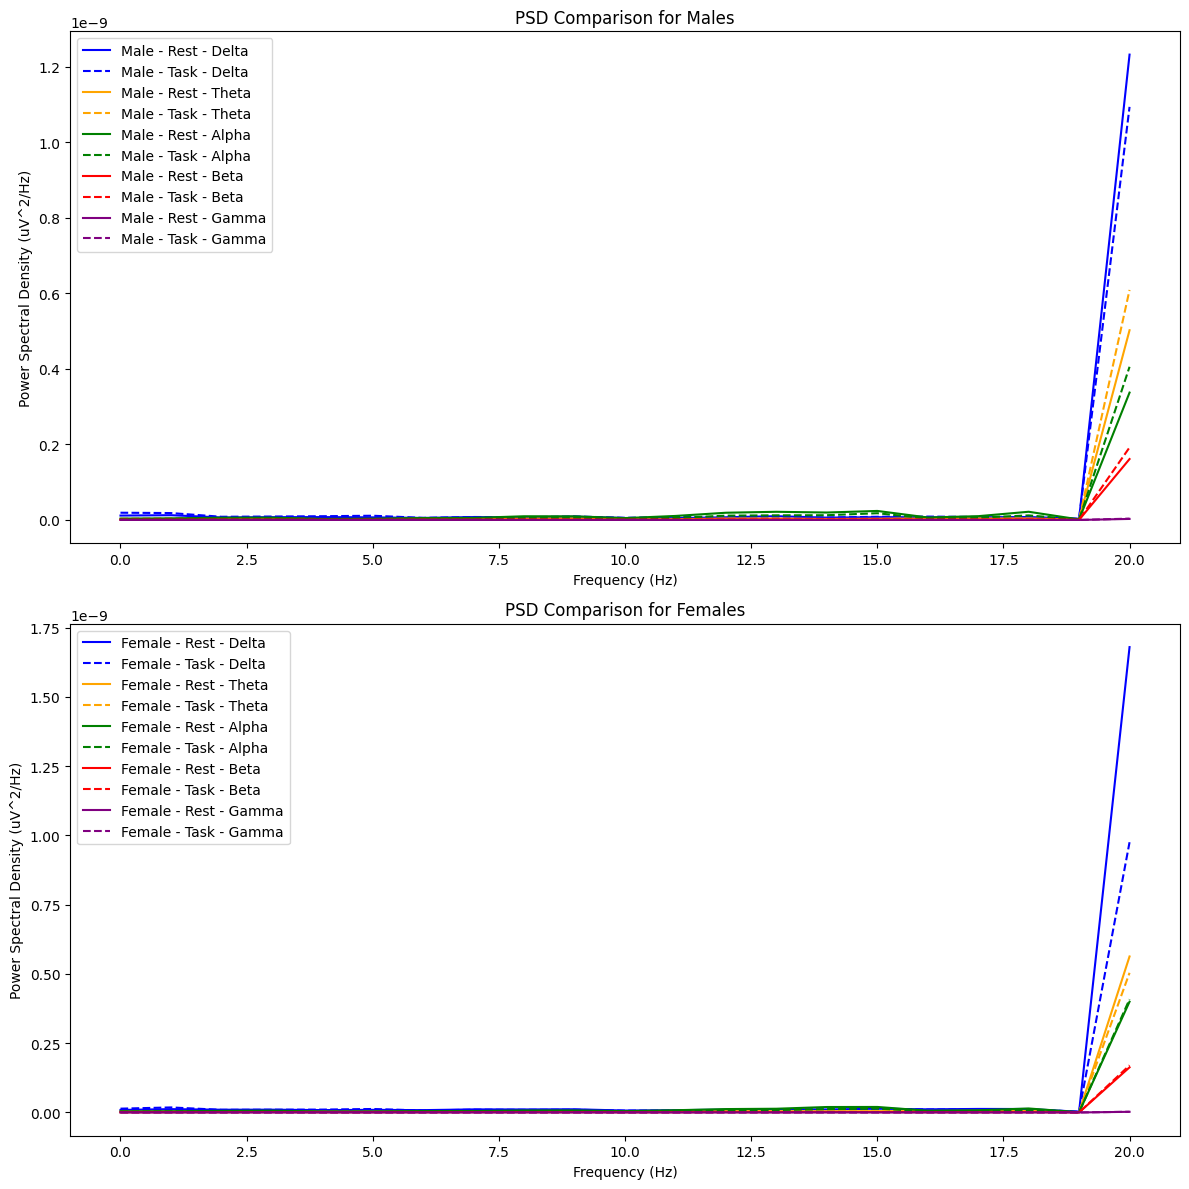

In [ ]:
# Defining colors for each frequency band
band_colors = {
    'Delta': 'blue',
    'Theta': 'orange',
    'Alpha': 'green',
    'Beta': 'red',
    'Gamma': 'purple'
}

plt.figure(figsize=(12, 12))

# Plot PSD comparison for males
plt.subplot(2, 1, 1)
plt.title('PSD Comparison for Males')
for band in freq_bands.keys():
    plt.plot(np.mean(psd_rest_all_male[band], axis=0), color=band_colors[band], linestyle='-', label=f'Male - Rest - {band}')
    plt.plot(np.mean(psd_task_all_male[band], axis=0), color=band_colors[band], linestyle='--', label=f'Male - Task - {band}')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (uV^2/Hz)')

# Plot PSD comparison for females
plt.subplot(2, 1, 2)
plt.title('PSD Comparison for Females')
for band in freq_bands.keys():
    plt.plot(np.mean(psd_rest_all_female[band], axis=0), color=band_colors[band], linestyle='-', label=f'Female - Rest - {band}')
    plt.plot(np.mean(psd_task_all_female[band], axis=0), color=band_colors[band], linestyle='--', label=f'Female - Task - {band}')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (uV^2/Hz)')

plt.tight_layout()
plt.show()

-> These graphs compares PSDs for male and female subjects separately.

-> We get to see some differences in PSD values when looking at male and female subjects separately, but these results can be inconsistent due to imbalance of data: number female subjects = 27 while number of male subjects = 9)

-> Noticible Differences :

In Males : PSD Delta Rest > PSD Delta Task; while in Females : PSD Delta Rest < PSD Delta Task

In Males : PSD Theta Rest < PSD Theta Task; while in Females : PSD Theta Rest > PSD Theta Task

In Males : PSD Alpha Rest < PSD Alpha Task; while in Females : PSD Alpha Rest = PSD Alpha Task approx.

In Males : PSD Beta Rest < PSD Beta Task; while in Females : PSD Beta Rest = PSD Beta Task approx.

Statistical analysis using p-value, it is the probability of observing the test results under the null hypothesis, which assumes no effect or no difference.


Significance of p-values in Hypothesis Testing :

->Small p-values (typically ≤ 0.05): Suggest that the observed data are unlikely under the null hypothesis. This often leads to rejecting the null hypothesis in favor of the alternative hypothesis, which indicates a significant difference or effect.

->Large p-values (> 0.05): Suggest that the observed data are likely under the null hypothesis. This means there is insufficient evidence to reject the null hypothesis, implying no significant difference or effect.


Interpretation:

-> A significant t-test result (small p-value) suggests that there is a significant difference in the means of the two conditions being compared (rest vs. task).

-> A non-significant result (large p-value) suggests no significant difference in the means.

In [ ]:
from scipy.stats import ttest_rel

# Function to compute average PSD over all 21 channels
def average_psd_over_channels(psd_data):
    return np.mean(psd_data, axis=1)

# Dictionary to store p-values
p_values = {'Overall': {}, 'Male': {}, 'Female': {}}

# Statistical tests for each frequency band
for band in freq_bands.keys():
    # All subjects
    rest_avg = average_psd_over_channels(np.array(psd_rest_all[band]))
    task_avg = average_psd_over_channels(np.array(psd_task_all[band]))
    t_stat, p_val = ttest_rel(rest_avg, task_avg)
    p_values['Overall'][band] = p_val

    # Male sunjects
    rest_avg_male = average_psd_over_channels(np.array(psd_rest_all_male[band]))
    task_avg_male = average_psd_over_channels(np.array(psd_task_all_male[band]))
    t_stat_male, p_val_male = ttest_rel(rest_avg_male, task_avg_male)
    p_values['Male'][band] = p_val_male

    # Female subjects
    rest_avg_female = average_psd_over_channels(np.array(psd_rest_all_female[band]))
    task_avg_female = average_psd_over_channels(np.array(psd_task_all_female[band]))
    t_stat_female, p_val_female = ttest_rel(rest_avg_female, task_avg_female)
    p_values['Female'][band] = p_val_female

for group in p_values.keys():
    print(f"P-values for {group}:")
    for band, p_val in p_values[group].items():
        print(f"{band} band: p-value = {p_val:.4f}")
    print()


P-values for Overall:
Delta band: p-value = 0.1249
Theta band: p-value = 0.4294
Alpha band: p-value = 0.1904
Beta band: p-value = 0.3359
Gamma band: p-value = 0.0604

P-values for Male:
Delta band: p-value = 0.4615
Theta band: p-value = 0.1879
Alpha band: p-value = 0.8913
Beta band: p-value = 0.0418
Gamma band: p-value = 0.0888

P-values for Female:
Delta band: p-value = 0.1438
Theta band: p-value = 0.0380
Alpha band: p-value = 0.1747
Beta band: p-value = 0.7327
Gamma band: p-value = 0.2629



Overall Subject Analysis :

-> No significant differences were observed in the Delta, Theta, Alpha, and Beta bands between rest and task states. This suggests that the cognitive state changes during the arithmetic task do not strongly affect these frequency bands.

-> The Gamma band shows a marginal difference, indicating some activity in higher frequency bands might be related to cognitive effort.


Gender-specific Subject Analysis: (again, these results can be inconsistent due to imbalance of data: number female subjects = 27 while number of male subjects = 9)

-> For males, there is a significant difference in the Beta band, and a marginally significant difference in the Gamma band, suggesting these bands are more sensitive to cognitive task changes in males.

-> For females, the Theta band shows a significant difference, indicating that females might exhibit changes in lower frequency bands during cognitive tasks.

In [ ]:

# Extracting features for rest and task states
def extract_features(raw_data):
    epochs = mne.make_fixed_length_epochs(raw_data, duration=1.0)
    features = epochs.get_data()
    return features

# Sets to store unique shapes
rest_shapes = set()
task_shapes = set()

rest_features = None
task_features = None
for index, row in df.iterrows():
    rest_feature = extract_features(row['rest_data'])
    task_feature = extract_features(row['task_data'])
    rest_shapes.add(rest_feature.shape)
    task_shapes.add(task_feature.shape)

    if rest_features is None:
        rest_features = rest_feature
        task_features = task_feature
    else:
        rest_features = np.concatenate((rest_features, rest_feature), axis=0)
        task_features = np.concatenate((task_features, task_feature), axis=0)


Not setting metadata
182 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 182 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
182 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 182 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
182 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 182 events and 500 original time points

In [ ]:
# Display the unique shapes
print("Unique shapes of rest_features:", rest_shapes)
print("Unique shapes of task_features:", task_shapes)

Unique shapes of rest_features: {(188, 21, 500), (170, 21, 500), (80, 21, 500), (182, 21, 500)}
Unique shapes of task_features: {(62, 21, 500)}


Shape of actual data points : (72, x, 21, 500) ; where x is inconsistent

This shape corresponds to (samples/subjects, segments/trials, channels/electrodes, time points/samples per segment)


Options to deal with inconsistent data and problems :

i. Padding : Introduces artificial data, inefficient

ii. Truncating : Loss of data

iii. Segmentation : Disrupts temporal continuity

Solution: We Flatten the data to make it consistent and use PCA (Principal Component Analysis) or UMAP (Uniform Manifold Approximation and Projection) for Data Reduction

Problems with this Solution : Loss of Structural Information and potential overfitting of models trained


Better Solution : Use Reshape, since channels and samples per segment are consistent in the data.

We can reshape it to (samples/subjects * segments/trials, channels/electrodes, time points/samples per segment)

Advantages: Makes the data consistent, maintains Structural Information, increases size of samples in data in significant amount which reduces overfitting, and several EEG classification models support Temporal data

In [ ]:
print(f"Shape of rest_features : {rest_features.shape}")
print(f"Shape of task_features : {task_features.shape}")

Shape of rest_features : (6444, 21, 500)
Shape of task_features : (2232, 21, 500)


In [ ]:
# Combine the features
X = np.vstack((rest_features, task_features))
print("Shape of X:", X.shape)

Shape of X: (8676, 21, 500)


In [ ]:
# Create labels (0 for rest, 1 for task)
rest_labels = [0] * len(rest_features)
task_labels = [1] * len(task_features)

y = np.array(rest_labels + task_labels)
print("Shape of y:", y.shape)

Shape of y: (8676,)


The chosen frequency bands are critical in EEG analysis because different frequency ranges are associated with various cognitive and physiological processes.

Significance of selected bands -

1. Delta (0.5 - 4 Hz): Associated with deep sleep and unconsciousness, prominent during slow-wave sleep.

2. Theta (4 - 8 Hz): Linked to light sleep, relaxation, and meditation; plays a role in memory formation and navigation.

3. Alpha/Mu (8 - 12 Hz): Related to relaxed wakefulness and meditative states; mu waves are specific to motor areas and mirror neuron activity.

4. Low Alpha (8 - 10 Hz): Indicative of a relaxed, yet alert mental state; often observed during quiet, restful states.

5. High Alpha (10 - 12 Hz): Seen during relaxed, focused states; can be increased with mindfulness and attention.

6. Beta (12 - 30 Hz): Associated with active thinking, focus, and problem-solving; present during cognitive and motor activities.

7. Low Beta (12 - 15 Hz): Related to relaxed focus and calm attention; often seen in tasks requiring sustained mental effort.

8. Mid Beta (15 - 20 Hz): Linked to active problem-solving and engagement; associated with alertness and excitement.

9. High Beta (20 - 30 Hz): Connected to heightened alertness, stress, and anxiety; seen during intense mental activity.

10. Gamma (30 - 100 Hz): Involved in high-level cognitive functions, sensory perception, and consciousness; linked to memory binding and integration.

11. Low Gamma (30 - 50 Hz): Plays a role in sensory processing and higher cognitive functions; often seen during focused attention.

12. High Gamma (50 - 100 Hz): Associated with complex problem-solving, peak performance, and heightened awareness.

13. Epsilon (0.1 - 0.5 Hz): Present in very deep meditative states and near-death experiences; not commonly observed in typical EEG studies.

14. Sigma (12 - 16 Hz): Characteristic of sleep spindles during Stage 2 sleep; involved in sleep maintenance and memory consolidation.

15. High-Frequency Oscillations (100 - 500 Hz): Linked to various cognitive and motor functions; often observed during rapid information processing.

16. Ripples (80 - 200 Hz): Associated with memory consolidation and information transfer in the hippocampus; seen during sharp wave-ripple events in sleep.

17. Fast Ripples (200 - 500 Hz): Related to pathological activity in epilepsy and high-frequency cognitive processes; may indicate regions prone to seizures.

Features are computed as the power within the band which is computed as the mean of the PSD values corresponding to these frequencies.

In [ ]:
from scipy.signal import welch

def extract_frequency_features(data, sfreq):
    n_samples, n_channels, n_times = data.shape
    freq_bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha/mu': (8, 12),
        'low_alpha': (8, 10),
        'high_alpha': (10, 12),
        'beta': (12, 30),
        'low_beta': (12, 15),
        'mid_beta': (15, 20),
        'high_beta': (20, 30),
        'gamma': (30, 100),
        'low_gamma': (30, 50),
        'high_gamma': (50, 100),
        'epsilon': (0.1, 0.5),
        'sigma': (12, 16),
        'high_frequency_oscillations': (100, 500),
        'ripples': (80, 200),
        'fast_ripples': (200, 500)
    }

    freq_features = np.zeros((n_samples, n_channels, len(freq_bands)))

    for i in range(n_samples):
        for j in range(n_channels):
            # Compute power spectral density (PSD) using Welch's method
            f, psd = welch(data[i, j, :], sfreq, nperseg=min(256, n_times))

            # Extract power in specified frequency bands
            for band, (f_low, f_high) in freq_bands.items():
                idx_band = np.where((f >= f_low) & (f < f_high))[0]
                if len(idx_band) > 0:
                    power_in_band = np.mean(psd[idx_band])
                else:
                    power_in_band = 0.0  # If no frequencies in band, set power to 0
                freq_features[i, j, list(freq_bands.keys()).index(band)] = power_in_band

    return freq_features

X_freq_features = extract_frequency_features(X, sfreq=500)
print('Shape of X_freq_features:', X_freq_features.shape)

Shape of X_freq_features: (8676, 21, 17)


Standardization is preferred due to the varying nature of EEG signals and the need to maintain the relative relationships between different channels and time points.

In [ ]:
# Standardize the freq_features
def standardize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    std[std == 0] = 1   # Avoid division by zero

    standardized_data = (data - mean) / std
    return standardized_data


X_standardized_freq_features = standardize_data(X_freq_features)
print("Standardized data shape:", X_standardized_freq_features.shape)

Standardized data shape: (8676, 21, 17)


In [ ]:
# One-hot encode the labels
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, num_classes=2)

In [ ]:
# Shuffle and split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_standardized_freq_features, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)   # (samples, channels, time)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (6940, 21, 17)
Shape of X_test: (1736, 21, 17)
Shape of y_train: (6940, 2)
Shape of y_test: (1736, 2)


Deciding appropiate models of our data :

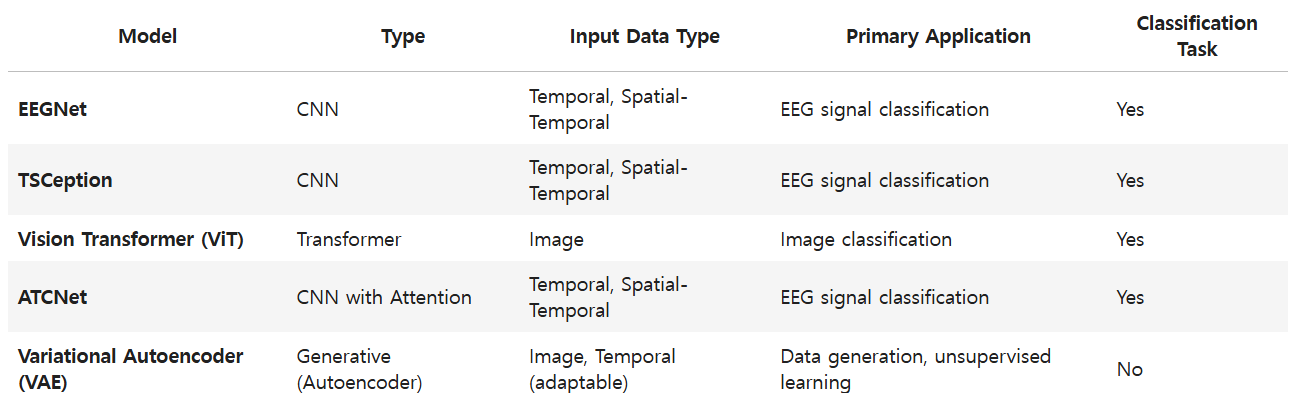

Since ViT is for image data and VAE is not for classification

Also, given the temporal EEG data, an LSTM (Long Short-Term Memory) RNN (Recurrent Neural Network) model is indeed a good choice. LSTMs are particularly effective in handling sequential data, such as time-series or EEG signals, due to their ability to learn and retain long-term dependencies

In [ ]:

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, Dropout, LSTM
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, Flatten, Dense, Input, Activation, multiply, Concatenate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


model_input_shape=(21, 17, 1)

accuracy_all = []
precision_all = []
recall_all = []
f1_all = []



# 1. EEGNet
EEGNet is a compact and efficient convolutional neural network (CNN) designed specifically for EEG signal classification. It uses depthwise and separable convolutions to reduce computational complexity while capturing both spatial and temporal dependencies in EEG data.

Architecture : Input -> Temporal Convolution -> Depthwise Convolution -> Separable Convolution -> BatchNorm -> Activation -> MaxPooling -> Dropout -> Dense (Classification)

In [ ]:
# EEGNet model architecture
def eegnet_model(input_shape):
    model = Sequential([
        # Convolutional Layers and Depthwise Convolutional Layers
        Conv2D(16, (1, 32), padding='same', kernel_regularizer=l2(0.01), input_shape=input_shape),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.25),

        DepthwiseConv2D((7, 1), depth_multiplier=2, depthwise_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.25),

        Conv2D(32, (1, 8), padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.25),

        # Pooling Layer to reduce dimensionality
        MaxPooling2D((1, 4)),

        # Another Depthwise Convolutional Layer and Convolutional Layer
        DepthwiseConv2D((5, 1), depth_multiplier=4, depthwise_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.25),

        Conv2D(64, (1, 4), padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Activation('elu'),
        Dropout(0.25),

        # Pooling Layer to further reduce dimensionality
        MaxPooling2D((1, 2)),

        # Flatten and dense layers
        Flatten(),
        Dense(32, activation='elu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),

        # Output Layer for binary classification
        Dense(2, activation='sigmoid')
    ])
    return model

# Create EEGNet model
model_eegnet = eegnet_model(model_input_shape)

# Compile the model
model_eegnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_eegnet = model_eegnet.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.7075 - loss: 2.2879 - val_accuracy: 0.7363 - val_loss: 1.4990
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.7671 - loss: 1.2962 - val_accuracy: 0.7428 - val_loss: 1.0185
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.7751 - loss: 0.9254 - val_accuracy: 0.7428 - val_loss: 0.8687
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7795 - loss: 0.7550 - val_accuracy: 0.7529 - val_loss: 0.7857
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.7930 - loss: 0.6705 - val_accuracy: 0.7464 - val_loss: 0.8722
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.8078 - loss: 0.6023 - val_accuracy: 0.7680 - val_loss: 0.6732
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.8039 - loss: 0.5819 - val_accuracy: 0.7939 - val_loss: 0.6002
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.8065 - loss: 0.5739 - 

In [ ]:
# Evaluate the EEGNet model
y_pred = model_eegnet.predict(X_test)

# Convert Probabilities to Discrete Labels, for binary classification, using a threshold of 0.5
y_pred = (y_pred > 0.5).astype(int)
y_pred = y_pred.astype(np.float32)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

accuracy_all.append(accuracy)
precision_all.append(precision)
recall_all.append(recall)
f1_all.append(f1)

# Display Metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Detailed Classification Report
report = classification_report(y_test, y_pred)
print("\nDetailed Classification Report:")
print(report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Accuracy: 0.7926
Precision: 0.8299
Recall: 0.7932
F1-score: 0.7358

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1298
           1       0.96      0.19      0.31       438

   micro avg       0.79      0.79      0.79      1736
   macro avg       0.87      0.59      0.60      1736
weighted avg       0.83      0.79      0.74      1736
 samples avg       0.79      0.79      0.79      1736



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 2. TSCeption
TSCeption is a deep learning model specifically designed to capture temporal patterns in multichannel time-series data, like EEG. It uses multiple temporal convolution layers with varying kernel sizes to extract features at different temporal scales.

Architecture : Input -> Conv(3x1) -> Conv(5x1) -> Conv(7x1) -> Concatenate -> Pooling -> Flatten -> Dense (Classification)

In [ ]:
# Reshape the data to include a channel dimension for TSCeption model
X_train_reshaped = X_train.reshape(-1, 21, 17)
X_test_reshaped = X_test.reshape(-1, 21, 17)

X_train_reshaped.shape

(6940, 21, 17)

In [ ]:
# TSCeption model architecture
def tsception_model(input_shape):
    inputs = Input(shape=input_shape)

    # 1D Convolutions across the features dimension
    t1 = Conv1D(16, 3, activation='relu', padding='same')(inputs)
    t2 = Conv1D(16, 5, activation='relu', padding='same')(inputs)
    t3 = Conv1D(16, 7, activation='relu', padding='same')(inputs)

    concatenated = Concatenate()([t1, t2, t3])
    pool = MaxPooling1D(pool_size=2)(concatenated)
    flat = Flatten()(pool)
    dense = Dense(64, activation='relu')(flat)

    # Output Layer for binary classification
    outputs = Dense(2, activation='softmax')(dense)

    return Model(inputs, outputs)


# Create the TSCeption model
model_tsception = tsception_model(X_train_reshaped.shape[1:])

# Compile the model
model_tsception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_tsception = model_tsception.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7332 - loss: 0.5682 - val_accuracy: 0.7983 - val_loss: 0.4457
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8322 - loss: 0.3889 - val_accuracy: 0.8271 - val_loss: 0.3908
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8617 - loss: 0.3257 - val_accuracy: 0.8300 - val_loss: 0.4227
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8817 - loss: 0.2750 - val_accuracy: 0.8638 - val_loss: 0.3431
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9068 - loss: 0.2277 - val_accuracy: 0.8754 - val_loss: 0.3246
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9148 - loss: 0.2010 - val_accuracy: 0.8818 - val_loss: 0.3172
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9319 - loss: 0.1756 - val_accuracy: 0.8905 - val_loss: 0.2977
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9420 - loss: 0.1526 - val_accuracy: 0.

In [ ]:
# Evaluate the TSCeption model
y_pred = model_tsception.predict(X_test_reshaped)

# Convert Probabilities to Discrete Labels, for binary classification, using a threshold of 0.5
y_pred = (y_pred > 0.5).astype(int)
y_pred = y_pred.astype(np.float32)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

accuracy_all.append(accuracy)
precision_all.append(precision)
recall_all.append(recall)
f1_all.append(f1)

# Display Metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Detailed Classification Report
report = classification_report(y_test, y_pred)
print("\nDetailed Classification Report:")
print(report)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9015
Precision: 0.8995
Recall: 0.9015
F1-score: 0.8985

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1298
           1       0.86      0.72      0.79       438

   micro avg       0.90      0.90      0.90      1736
   macro avg       0.89      0.84      0.86      1736
weighted avg       0.90      0.90      0.90      1736
 samples avg       0.90      0.90      0.90      1736



# 3. LSTM RNN
LSTMs are particularly effective in handling sequential data, such as time-series or EEG signals, due to their ability to learn and retain long-term dependencies.

In [ ]:
# LSTM model architecture
def lstm_model(input_shape):
    model = Sequential()

    # LSTM layers
    model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Fully connected Dense layers
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Output Layer for binary classification
    model.add(Dense(units=2, activation='softmax'))

    return model

# Create ATCNet model instance
model_lstm = lstm_model((21, 17))

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.5695 - loss: 0.7723 - val_accuracy: 0.7493 - val_loss: 0.5412
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.7022 - loss: 0.6165 - val_accuracy: 0.7421 - val_loss: 0.5312
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.7464 - loss: 0.5533 - val_accuracy: 0.7486 - val_loss: 0.5188
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.7342 - loss: 0.5404 - val_accuracy: 0.7651 - val_loss: 0.5056
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.7744 - loss: 0.4931 - val_accuracy: 0.7572 - val_loss: 0.5318
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.7698 - loss: 0.4991 - val_accuracy: 0.7709 - val_loss: 0.4789
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7865 - loss: 0.4609 - val_accuracy: 0.7824 - val_loss: 0.4683
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.7758 - loss: 0

In [ ]:
# Evaluate the LSTM RNN model
y_pred = model_lstm.predict(X_test)

# Convert Probabilities to Discrete Labels, for binary classification, using a threshold of 0.5
y_pred = (y_pred > 0.5).astype(int)
y_pred = y_pred.astype(np.float32)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

accuracy_all.append(accuracy)
precision_all.append(precision)
recall_all.append(recall)
f1_all.append(f1)

# Display Metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Detailed Classification Report
report = classification_report(y_test, y_pred)
print("\nDetailed Classification Report:")
print(report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Accuracy: 0.8076
Precision: 0.8030
Recall: 0.8076
F1-score: 0.8050

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1298
           1       0.63      0.58      0.60       438

   micro avg       0.81      0.81      0.81      1736
   macro avg       0.75      0.73      0.74      1736
weighted avg       0.80      0.81      0.80      1736
 samples avg       0.81      0.81      0.81      1736



# Results
## Metrics :

Accuracy: The ratio of correctly predicted instances to the total instances. It is a good general measure but can be misleading if the classes are imbalanced.

Precision: The ratio of correctly predicted positive observations to the total predicted positives. It is crucial when the cost of false positives is high.

Recall (Sensitivity): The ratio of correctly predicted positive observations to all observations in the actual class. It is important when the cost of false negatives is high.

F1-score: The weighted average of Precision and Recall. It balances both precision and recall and is useful when you need a single measure to evaluate the performance.

In [ ]:
# Model names
models = ['EEGNet', 'TSCeption', 'LSTM RNN']

metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1-score': f1_all
})
metrics_df.set_index('Model', inplace=True)

# Display
print("Model Evaluation Metrics:")
print(metrics_df)

Model Evaluation Metrics:
           Accuracy  Precision    Recall  F1-score
Model                                             
EEGNet     0.792627   0.829872  0.793203  0.735791
TSCeption  0.901498   0.899541  0.901498  0.898465
LSTM RNN   0.807604   0.803037  0.807604  0.804963


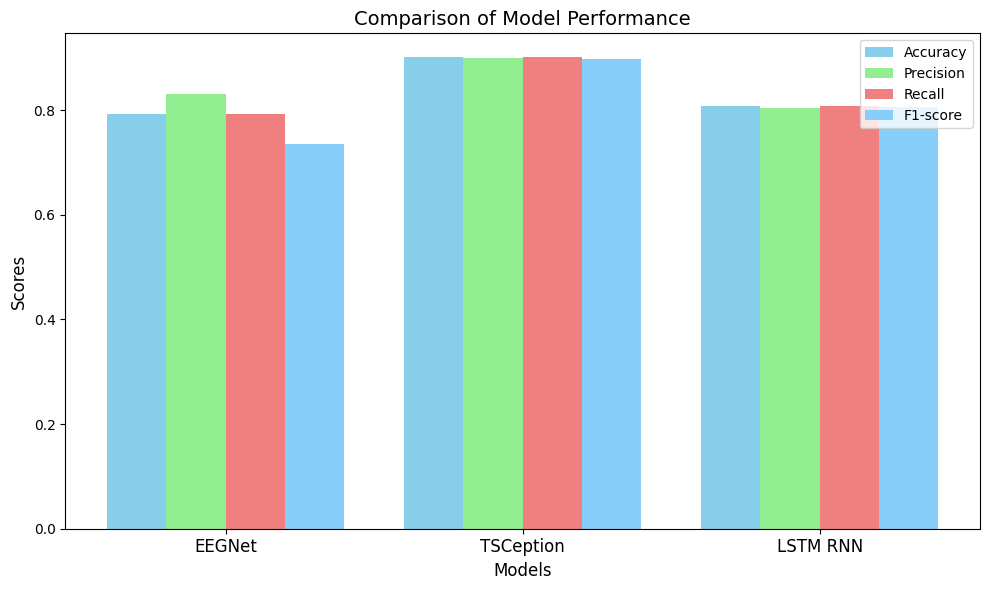

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 성능 지표를 저장한 데이터프레임
models = ['EEGNet', 'TSCeption', 'LSTM RNN']
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_all,
    'Precision': precision_all,
    'Recall': recall_all,
    'F1-score': f1_all
})
metrics_df.set_index('Model', inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# 막대 그래프의 x축 위치 설정
x = np.arange(len(models))

# 각 지표별로 막대그래프 그리기
width = 0.2  # 막대의 너비

# 성능 지표별 막대 그래프 그리기
ax.bar(x - width * 1.5, metrics_df['Accuracy'], width, label='Accuracy', color='skyblue')
ax.bar(x - width * 0.5, metrics_df['Precision'], width, label='Precision', color='lightgreen')
ax.bar(x + width * 0.5, metrics_df['Recall'], width, label='Recall', color='lightcoral')
ax.bar(x + width * 1.5, metrics_df['F1-score'], width, label='F1-score', color='lightskyblue')

# 레이블 및 제목 설정
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Model Performance', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# 성능 비교 그래프 표시
plt.tight_layout()
plt.show()


## Accuracy: TSCeption has the highest accuracy at 90.49%, indicating it correctly predicts the highest proportion of instances overall.

## Precision vs. Recall:

-> Precision is highest in TSCeption, meaning it is best at minimizing false positives.

-> Recall is highest in ATCNet, meaning it is best at minimizing false negatives.

F1-Score: TSCeption again leads with the highest F1-score, which means it maintains a good balance between precision and recall.


## Conclusion : TSCeption is the best overall performing model across most metrics.